In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define the LSTM model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
       # self.linear = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        out, _ = self.rnn(x)
        #out = self.linear(out)
        out = self.relu(out[:, -1, :])  # Use the output from the last time step
        return out

# Function to create sequences using a sliding window
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

# Main function to train the LSTM model
def train_LSTM(data, features, target, date_col, year_test_start, year_test_end, seq_len=52):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert date column to datetime
    data[date_col] = pd.to_datetime(data[date_col])
    data = data.sort_values(by=date_col).dropna()

    # Split data into training and testing sets
    train_data = data[data[date_col] < year_test_start]
    test_data = data[(data[date_col] >= year_test_start) & (data[date_col] <= year_test_end)]

    # Extract features and target
    X_train = train_data[features].values
    y_train = train_data[[target]].values
    X_test = test_data[features].values
    y_test = test_data[[target]].values

    # Scale the features and target
    """
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, seq_len)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, seq_len)
    """

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train, seq_len)
    X_test_seq, y_test_seq = create_sequences(X_test, seq_len)


    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).to(device)
    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize the model, loss function, and optimizer
    model = RNNModel(input_size=len(features)).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 2000
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Periodic evaluation
        if (epoch+1) % 20 == 0:
            model.eval()
            with torch.no_grad():
                train_preds = model(X_train_tensor).cpu().numpy()
                train_true = y_train_tensor.cpu().numpy()
                train_rmse = np.sqrt(np.mean((train_preds - train_true) ** 2))

                test_preds = model(X_test_tensor).cpu().numpy()
                test_true = y_test_tensor.cpu().numpy()
                test_rmse = np.sqrt(np.mean((test_preds - test_true) ** 2))

            print(f"Epoch {epoch+1}/{num_epochs}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    # Final evaluation
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test_tensor).cpu().numpy()
        test_true = y_test_tensor.cpu().numpy()

    # Inverse transform
    #test_preds = scaler_y.inverse_transform(test_preds)
    #test_true = scaler_y.inverse_transform(test_true)

    # Calculate MAE and MSE
    mae = np.mean(np.abs(test_preds - test_true))
    mse = np.mean((test_preds - test_true) ** 2)

    return test_preds, mae, mse




In [2]:
import sys
sys.path.append('..')
import models_utils

In [3]:
municipals = []
with (open("../municipals.txt", "r") as f):
    for line in f:
        municipals.append(line.strip())
municipals

['Ajuy',
 'Alimodian',
 'Anilao',
 'Badiangan',
 'Balasan',
 'Banate',
 'Barotac Nuevo',
 'Barotac Viejo',
 'Batad',
 'Bingawan',
 'Cabatuan',
 'Calinog',
 'Carles',
 'Passi City',
 'Concepcion',
 'Dingle',
 'Duenas',
 'Dumangas',
 'Estancia',
 'Guimbal',
 'Igbaras',
 'Janiuay',
 'Lambunao',
 'Leganes',
 'Lemery',
 'Leon',
 'Maasin',
 'Miagao',
 'Mina',
 'New Lucena',
 'Oton',
 'Pavia',
 'Pototan',
 'San Dionisio',
 'San Enrique',
 'San Joaquin',
 'San Miguel',
 'San Rafael',
 'Santa Barbara',
 'Sara',
 'Tigbauan',
 'Tubungan',
 'Zarraga']

In [4]:
n_weeks_ahead = [1,2,3,4,5,6,7,8,9,10,11,12]
features = ["Temperature", "Precipitation", "Humidity", "Population", "Week", "Month", "Cases"]

for municipal in municipals:
    municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
    municipal_df["Year-Week"] = pd.to_datetime(municipal_df["Year-Week"])

    for n in n_weeks_ahead:
        n_date = pd.to_datetime("2023-01-02") - pd.DateOffset(weeks=n)

        if len(municipal_df[municipal_df["Year-Week"] < n_date]) >= n:
            predicted, MAE, MSE = train_LSTM(
                municipal_df,
                features=features,
                target="Cases",
                date_col="Year-Week",
                seq_len=n,
                year_test_start=n_date,
                year_test_end="2024-12-31"
            )
            predicted = [max(0, int(round(p))) for p in predicted]
            models_utils.save_data(municipal, n, MSE, MAE, predicted, municipal_df, type="Municipal")
        else:
            print(f"Skipped {municipal} (n={n}) due to insufficient training data.")


/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 7])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([17, 7])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/2000, Train RMSE: 0.8845, Test RMSE: 1.1059


KeyboardInterrupt: 

In [6]:
summed_df_list = []
for municipal in municipals:
    municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
    # lag the features
    municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", 1)
    summed_df_list.append(municipal_df)
summed_df = models_utils.prepare_dataframe_summed(summed_df_list)
summed_df

/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/model/Recurrent-Neural-Network/../models_utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/model/Recurrent-Neural-Network/../models_utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/model/Recurrent-N

,Year-Week,Temperature,Humidity,Precipitation,Cases,Population,Year,Month,Week
0,2014-04-07,29.085999,69.510519,2.800000,13.0,44424.502326,2014,4,15
1,2014-04-14,28.544785,71.990878,30.800000,8.0,44424.502326,2014,4,16
2,2014-04-21,27.360928,81.830299,224.799993,7.0,44424.502326,2014,4,17
3,2014-04-28,28.839500,75.587553,61.600004,10.0,44424.502326,2014,4,18
4,2014-05-05,29.867644,76.199511,8.800000,15.0,44424.502326,2014,5,19
...,...,...,...,...,...,...,...,...,...
555,2024-12-02,29.499572,75.246312,40.500002,104.0,49329.874419,2024,12,49
556,2024-12-09,28.566571,77.246023,56.100003,135.0,49329.874419,2024,12,50
557,2024-12-16,26.914858,85.227285,122.400006,113.0,49329.874419,2024,12,51
558,2024-12-23,27.752500,80.047471,68.699999,84.0,49329.874419,2024,12,52


In [27]:
features = ["Temperature", "Precipitation", "Humidity", "Population", "Week", "Month", "Cases"]
n_date = pd.to_datetime("2023-01-02") - pd.DateOffset(weeks=52)
predicted, MAE, MSE = train_LSTM(
    summed_df,
    features=features,
    target="Cases",
    date_col="Year-Week",
    seq_len=12,
    year_test_start=n_date,
    year_test_end="2024-12-31"
)
MSE

/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 7])) that is different to the input size (torch.Size([32, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (64) must match the size of tensor b (7) at non-singleton dimension 1

In [24]:
MSE**(1/2)


18589.010947331222

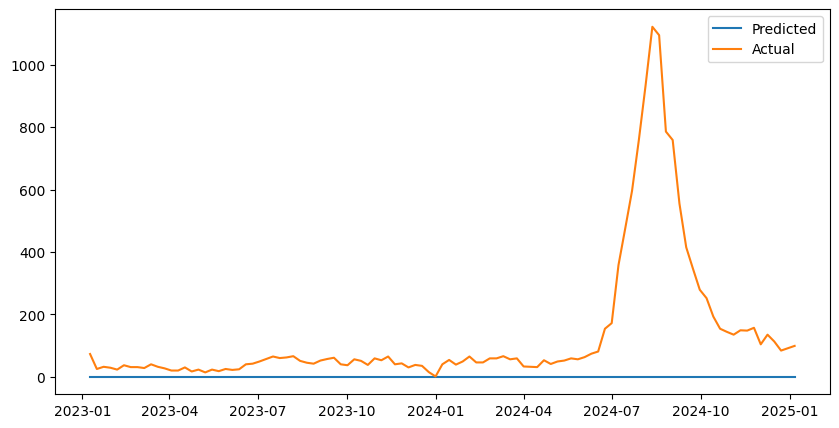

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(summed_df["Year-Week"].values[-104:],predicted[-104:], label='Predicted')
plt.plot(summed_df["Year-Week"].values[-104:],summed_df["Cases"].values[-104:], label='Actual')
plt.legend()

In [72]:
len(predicted)

144